## Angelos Gkouveris - Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  the goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [4]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.`Read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [5]:
df =pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [6]:
# Find Number or colums and rows
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [7]:
#User_id as the number unique users 
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [8]:
#Nunmber of uses converted
(df.converted == True).sum()

35237

In [9]:
#The proportion of users converted.
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [10]:
# Number of times that in the dataframe matches only old_page & treatment
df_t=(df.query('group == "treatment"')['landing_page'] == 'old_page').sum()
df_c=(df.query('group == "control"')['landing_page'] == 'new_page').sum()
df_t + df_c


3893

f. Rows that have missing values?

In [11]:
#Find the nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Now we create a new dataset that meets the specifications and  Store the new dataframe in **df2**.

In [12]:
df2 = df.query("group == 'control' and landing_page == 'old_page'")
df2 = df2.append(df.query("group == 'treatment' and landing_page == 'new_page'"))

In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [14]:
#Number of unique users_id
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [15]:
# Number of duplicated rows in the dataframe with the same user_id
sum(df2.user_id.duplicated())


1

c. What is the row information for the repeat **user_id**? 

In [16]:
# Get the duplicated row  
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep the dataframe as **df2**.

In [17]:
# Drop the duplicate row number(2893) from dataframe
df2 = df2.drop(2893)

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
#By getting the mean of converted we can find the propability
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
#The probability in the control group and converted is 0.1204
df2.groupby('group')['converted'].mean()

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
#The probability in the treatment group and converted is 0.1188
df2.groupby('group')['converted'].mean()

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

d. What is the probability that an individual received the new page?

In [21]:
#Count number of new_pages and old_pages and divide
#them by the total lenght of our dataframe we can get the two probabilities 
df2.landing_page.value_counts() / len(df2)


new_page    0.500062
old_page    0.499938
Name: landing_page, dtype: float64

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

#### The probability of an individual received the new page is slightly bigger than the old page.Ηowever,In order to get reliable results we have to implement hypothesis test and reach in accurate conclusion.

<a id='ab_test'></a>
### Part II - A/B Test

`1.` For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{old} - p_{new} \geq 0$$


$$H_1: p_{old}- p_{new} < 0$$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>



a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
#The probability of conversion rate for  P𝑛𝑒𝑤  under the null.
null_new = (df2.converted == 1).mean()
null_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
#The probability of conversion rate for  Pold  under the null.
null_old = (df2.converted == 1).mean()
null_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
#The number of individuals in the treatment group
n_new = df2.groupby('group')['user_id'].count()
n_new

group
control      145274
treatment    145310
Name: user_id, dtype: int64

d. What is $n_{old}$, the number of individuals in the control group?

In [25]:
# the number of individuals in the control group
n_old = df2.groupby('group')['user_id'].count()
n_old

group
control      145274
treatment    145310
Name: user_id, dtype: int64

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted =  np.random.binomial(n_new,null_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted =  np.random.binomial(n_old,null_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
#In order to find probabilities we have to diviate The P𝑛𝑒w -  P𝑜𝑙𝑑 
#by their invidual numbers  
diff = new_page_converted.mean() - old_page_converted.mean()
diff

-116.5

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new, null_new).mean()
    old_page_converted = np.random.binomial(n_old, null_old).mean()
    p_diffs.append(new_page_converted-old_page_converted)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

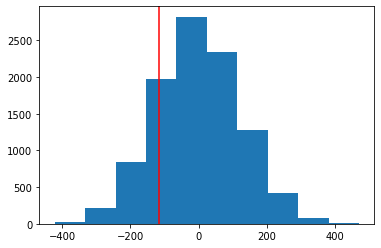

In [30]:
#Convert to array
p_diffs= np.array(p_diffs)
#Create a normal distribution centered at zero
null_vals=np.random.normal(0,p_diffs.std(),p_diffs.size)
#Observe statistic falls
plt.hist(null_vals);
plt.axvline(diff,c='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
#Find the P-value
(null_vals < diff).mean()

0.1753

k.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

##### The given result in j question  is  statistical significant as P-value is larger than Type I error rate​ 0.5 It is seems that our statistic is from the null. So we do not reject null hypothesis,control  have higher conversion rates than the treatment : 
$$H_0: p_{old} - p_{new} \geq 0$$


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum() 
convert_new = df2.query('group == "treatment"')['converted'].sum() 
n_old = df2.query('landing_page == "old_page"').shape[0] 
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  

In [33]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_old, n_new], alternative="smaller")
z_score, p_value

(-1.2616957421858055, 0.1035291448032774)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

###### We could summarize that the computation of z-score and p-value verifie the conclusion in question (J). Empirically Z-Score critical value is between (-1.96 – 1.96)  furthermore P-value it seems to be close to 0.1 that means that the conversion rates of the old and new pages are not statistically different,again we fail reject the null hypothesis.



<a id='regression'></a>
### Part III - A regression approach

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

#### In order to predict categorical variables such as control & treatment group we need to use logistic regression.

b. The goal is to use **statsmodels** to fit the regression model  specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, first we need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
#Create 0 and 1 column for control and treatmnet group
df2[['control','treatment']] = pd.get_dummies(df2['group'])
df2['ab_page'] = df2['treatment']

c. Use **statsmodels** to instantiate  regression model on the two columns you created in part b., then fit the model using the two columns we created in part **b.** to predict whether or not an individual converts. 

In [35]:
#Use logit regression model
df2['intercept'] = 1 
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
#Summary statistics 
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
results=log_mod.fit()
results.summary()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 Sep 2020   Pseudo R-squ.:               8.077e-06
Time:                        18:32:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**?

##### First of all P- value is 0.19 which means is not statistical significant as type error 1 is equal 0.05.In contrast of part II result , in this case we reject the null hypothesis and we choose alternative(H0 ≠ H1).

f. Now, considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

#### We can summarize that control & treatment group are not longer appropriate variables to conclude whether a user convert or not,thus we need to add more variables. However x- variables should be correlated with the response but not with each other

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. We will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  

In [39]:
#Create the dataframe
df_coun = pd.read_csv('countries.csv')
#To check user_id for each country
df1 = df_coun.groupby('country').count()
df1


,user_id
country,
CA,14499
UK,72466
US,203619


In [40]:
#Merge two datasets
df_new=df2.set_index('user_id').join(df_coun.set_index('user_id'))
df_new.head()

,timestamp,group,landing_page,converted,control,treatment,ab_page,intercept,country
user_id,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1,US
936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,0,1,US
719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,0,1,US


h. Though now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and conclusions based on the results.

In [41]:
#Create dummy variable to change the country to a categorical variable
df_new[['CAN','UK','US']]= pd.get_dummies(df_new['country'])
df_new['country'].astype(str).value_counts()


US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [42]:
#Fit a logistic model to predict if there is  interaction between page and country
df_new['intercept'] = 1
logit_mod=sm.Logit(df_new ['converted'],df_new[['intercept','UK', 'US']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 23 Sep 2020   Pseudo R-squ.:               1.521e-05
Time:                        18:41:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

#### To conclude all country's variables are not statistically significantas p-values are larger than 0.05.Which means there is not correlation between pages and countries.

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])